## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [6]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  89.9M      0  0:00:08  0:00:08 --:--:-- 78.1M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
subfolder contains image files for each category.

In [4]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [5]:
import os  # Import the os module for working with file paths and directories

# Counter to keep track of the number of deleted corrupted images
num_skipped = 0

# Loop through both "Cat" and "Dog" folders inside "PetImages"
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)  # Construct the folder path

    # Loop through each file in the current folder
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)  # Construct the full file path

        try:
            # Open the file in binary read mode to check its format
            fobj = open(fpath, "rb")
            # Check if the first 10 bytes contain "JFIF", indicating a valid JPEG file
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            # Ensure the file is closed after checking
            fobj.close()

        # If the file is not a valid JFIF JPEG image, delete it
        if not is_jfif:
            num_skipped += 1  # Increment the count of deleted files
            os.remove(fpath)  # Remove the corrupted image file

# Print the number of deleted corrupted images
print(f"Deleted {num_skipped} images.")


Deleted 1590 images.


## Generate a `Dataset`

In [8]:
import keras  # Import Keras (ensure TensorFlow is installed)

# Define the target size for images (width, height)
image_size = (180, 180)

# Define the batch size (number of images processed at a time)
batch_size = 128

# Load images from the "PetImages" directory and split into training & validation datasets
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",          # Path to the image dataset folder
    validation_split=0.2, # 20% of the data will be used for validation
    subset="both",        # Load both training and validation datasets
    seed=1337,            # Set a random seed for reproducibility
    image_size=image_size, # Resize all images to (180,180)
    batch_size=batch_size # Load images in batches of 128
)

# The function automatically labels images based on subfolder names (e.g., "Cat", "Dog")


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.

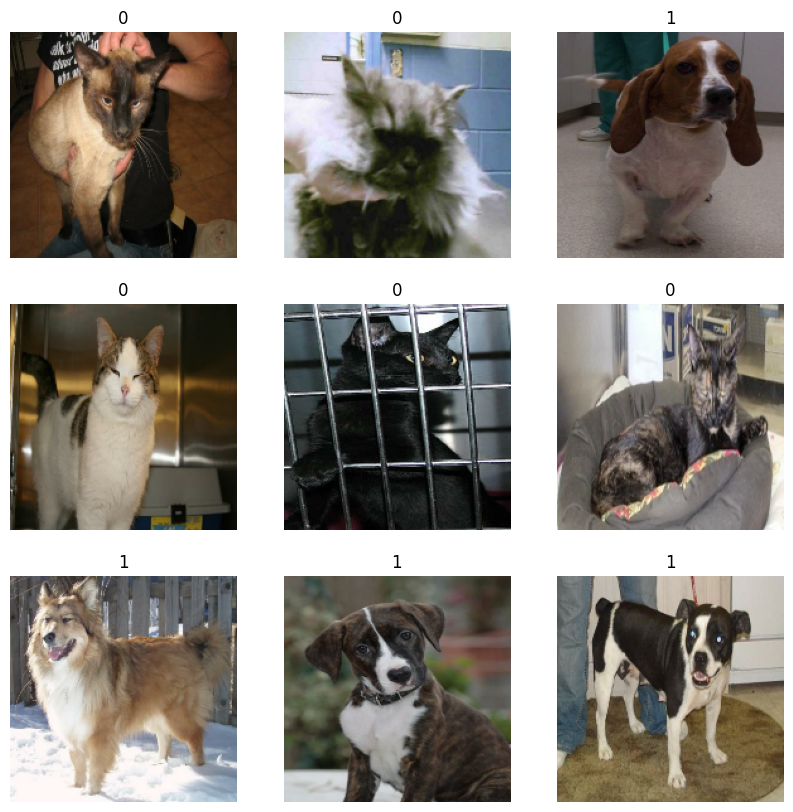

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with a size of 10x10 inches
plt.figure(figsize=(10, 10))

# Take one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    # Loop through the first 9 images in the batch
    for i in range(9):
        # Create a subplot grid of 3x3 and place the current image in position (i+1)
        ax = plt.subplot(3, 3, i + 1)

        # Convert the image tensor to a NumPy array and ensure it's in uint8 format for display
        plt.imshow(np.array(images[i]).astype("uint8"))

        # Set the title of the image to its corresponding label (converted to int)
        plt.title(int(labels[i]))

        # Remove axis ticks and labels for a cleaner look
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [11]:
from tensorflow.keras import layers  # Importing necessary module

# Define a list of data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),  # Randomly flips images horizontally (left to right)
    layers.RandomRotation(0.1),  # Randomly rotates images by up to 10% of 360 degrees
]

def data_augmentation(images):
    """
    Applies data augmentation to input images using the defined layers.

    Args:
        images: A batch of images (tensor) to be augmented.

    Returns:
        Augmented images after applying transformations.
    """
    for layer in data_augmentation_layers:
        images = layer(images)  # Apply each augmentation layer sequentially
    return images  # Return the augmented images


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

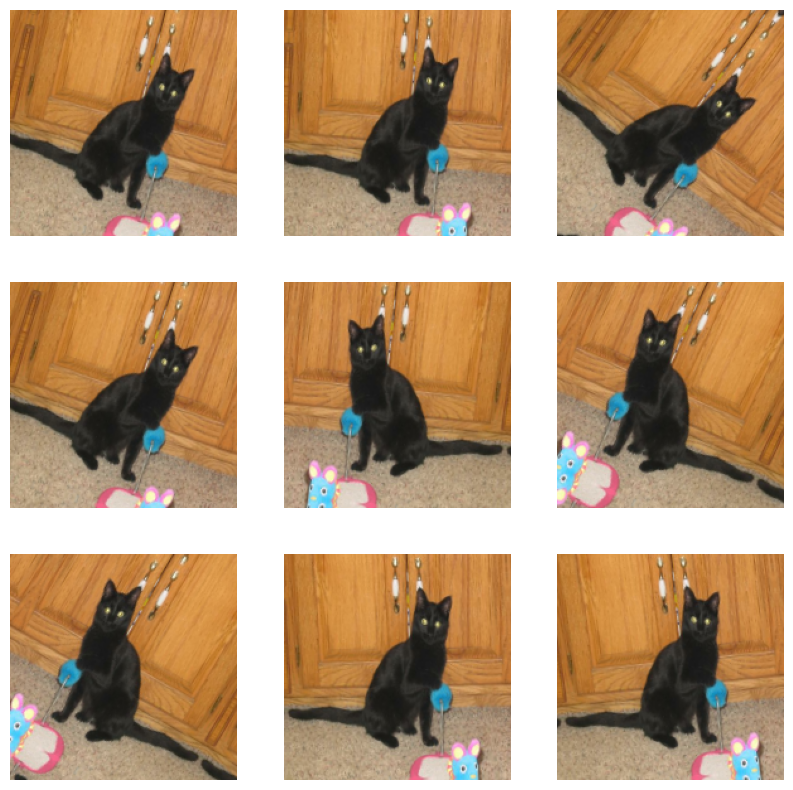

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))  # Create a figure with a size of 10x10 inches

# Take a single batch from the training dataset (train_ds)
for images, _ in train_ds.take(1):
    for i in range(9):  # Loop to display 9 augmented images
        augmented_images = data_augmentation(images)  # Apply data augmentation to the images

        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid subplot and select the (i+1)th position
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))  # Convert image to uint8 format and display it
        plt.axis("off")  # Hide the axis labels for a cleaner look


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [13]:
# Apply data augmentation to the training images.
# This helps improve the model's ability to generalize by creating variations
# of the images (e.g., flipping, rotating, zooming).
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),  # Apply augmentation only to images, keeping labels unchanged.
    num_parallel_calls=tf_data.AUTOTUNE,  # Optimize performance by parallelizing the operation.
)

# Prefetching allows the dataset to fetch batches in advance,
# reducing CPU-GPU data transfer bottlenecks and improving training speed.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)  # Prefetch training dataset to keep the GPU busy.
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)  # Prefetch validation dataset for efficient evaluation.


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

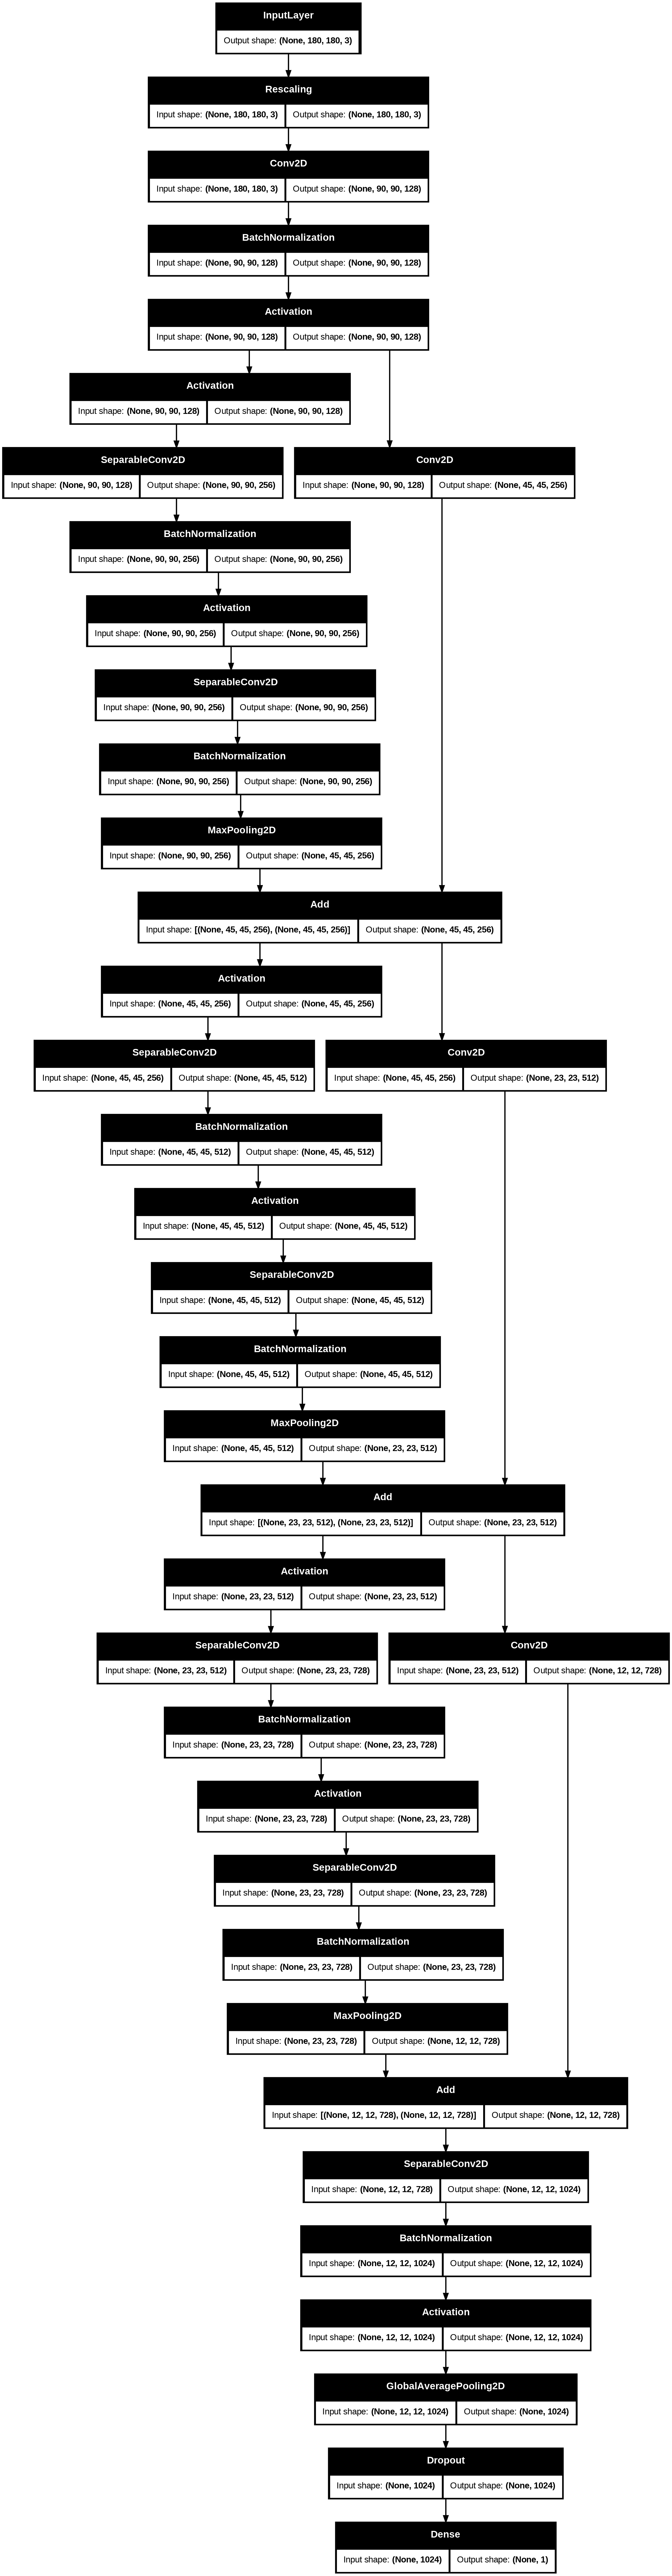

In [14]:
import keras
from keras import layers

def make_model(input_shape, num_classes):
    # Define the input layer with the specified shape
    inputs = keras.Input(shape=input_shape)

    # Entry block: Normalize pixel values to [0,1] range
    x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale input values from [0, 255] to [0, 1]

    # Initial convolutional layer with stride 2 to downsample the input
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)  # Normalize activations for stable training
    x = layers.Activation("relu")(x)  # Apply ReLU activation

    # Store the current activation for residual connections
    previous_block_activation = x

    # Main feature extraction blocks (similar to Xception or ResNet)
    for size in [256, 512, 728]:  # Increasing filter sizes in deeper layers
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)  # Depthwise separable conv for efficiency
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)  # Another separable conv layer
        x = layers.BatchNormalization()(x)

        # Downsample using MaxPooling and match the shape using a residual connection
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual (1x1 conv to match dimensions)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)

        # Add residual connection to the main path
        x = layers.add([x, residual])

        # Update the previous block activation for the next residual connection
        previous_block_activation = x

    # Final convolutional layer before classification
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Global average pooling to reduce feature maps to a single vector per sample
    x = layers.GlobalAveragePooling2D()(x)

    # Determine the number of output units based on class count
    if num_classes == 2:
        units = 1  # Binary classification (single output neuron)
    else:
        units = num_classes  # Multi-class classification (one neuron per class)

    x = layers.Dropout(0.25)(x)  # Apply dropout for regularization

    # Output layer (logits) - no activation function applied here
    outputs = layers.Dense(units, activation=None)(x)

    # Create and return the model
    return keras.Model(inputs, outputs)


# Define the model with input shape and number of classes
model = make_model(input_shape=image_size + (3,), num_classes=2)

# Visualize the model architecture
keras.utils.plot_model(model, show_shapes=True)


## Train the model

In [16]:
# Number of times the model will iterate over the entire dataset
epochs = 25

# Define callbacks: Save the model at each epoch checkpoint
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),  # Saves model after each epoch
]

# Compile the model with an optimizer, loss function, and evaluation metrics
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),  # Adam optimizer with a learning rate of 0.0003
    loss=keras.losses.BinaryCrossentropy(from_logits=True),  # Binary cross-entropy loss for classification
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],  # Track binary accuracy during training
)

# Train the model using the training dataset
model.fit(
    train_ds,  # Training dataset
    epochs=epochs,  # Number of training iterations
    callbacks=callbacks,  # Use checkpointing callback to save the model at each epoch
    validation_data=val_ds,  # Validation dataset to check performance after each epoch
)


Epoch 1/25


KeyboardInterrupt: 

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This image is 99.97% cat and 0.03% dog.


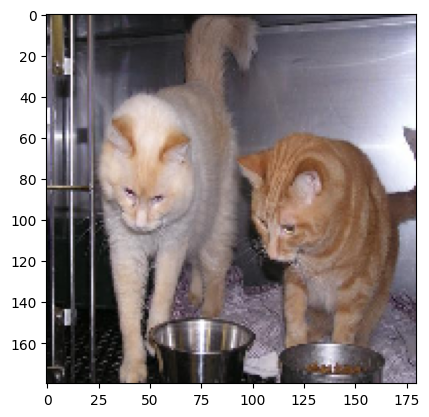

In [19]:
img = keras.utils.load_img("PetImages/Cat/5769.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")